In [15]:
import math, os, sys, copy, pickle
from skimage import io, filters, restoration
from skimage import morphology as morph
import PIL
from PIL import Image, ImageSequence, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
# import cv2
import multipagetiff as mtif

In [16]:
def plot(tif_files, try_denoise = False):
    fig, axes = plt.subplots(2, 4, figsize=(16,8), sharex=True, sharey=True)
    for num, tif_file in enumerate(tif_files):
        #print(tif_file, tif_file.rsplit(".", 1)[0][-1])
        # num = int(tif_file.rsplit(".", 1)[0][-1])-1

        im = Image.open(tif_file)
        if denoise:
            imarray = denoise(np.array(im))
        else:
            imarray = np.array(im)
        # print(num, num//4, num%4)
        axes[num//4, num%4].imshow(imarray)
        axes[num//4, num%4].set_title("{}".format(num+1))
    plt.show()
    # plt.colorbar()
#     fig.subplots_adjust(right=0.85)
#     cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
#     fig.colorbar(im, cax=cbar_ax)

def plot_oneZ(tif_files, z_pos = 0, z_num = 0):
    fig, axes = plt.subplots(2, 4, figsize=(16,8), sharex=True, sharey=True)
    for tif_file in tif_files:
        #print(tif_file, tif_file.rsplit(".", 1)[0][-1])
        num = int(tif_file.rsplit(".", 1)[0][-1])-1
        imgs = mtif.read_stack(tif_file)
        if z_num != 0:
            img = imgs[z_num - 1]
        else:
            img = imgs[math.floor(len(imgs) * z_pos)]
        # print(num, num//4, num%4)
        axes[num//4, num%4].imshow(img)
        axes[num//4, num%4].set_title("{}".format(num+1))
    plt.show()
    
def plot_single(img):
    #print(tif_file, tif_file.rsplit(".", 1)[0][-1])
    # im = Image.open(tif_file)
    # img = np.array(im)
    plt.figure()
    ax = plt.gca()
    im_vis = ax.imshow(img)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_vis, cax=cax)
    plt.show()

def flatten_plot(tif_files):
    # fig, axes = plt.subplots(2,4, figsize=(16,8), sharex = True, sharey = True)
    plt.figure(figsize=(16,8))
    for i, tif_file in enumerate(tif_files):
        imgs = mtif.read_stack(tif_file)
        plt.subplot(2,4,i+1)
        img = mtif.flatten(imgs)
        plt.imshow(img)
    plt.tight_layout()

In [17]:
def normalize(img, im_max = None, im_min = 0, scale_to = 65535):
    img_new = copy.deepcopy(img)
    if im_max == None:
        im_max = np.max(img)
    if im_min == None:
        im_min = np.min(img)
    img_new = (img - im_min) / (im_max - im_min)
    img_new = np.array(img_new * scale_to).astype(np.uint16)
    return(img_new)

def filter(img, threshold = None):
    if threshold == None:
        threshold = filters.threshold_otsu(img)
    mask = img > threshold
    otsu_filtered = np.zeros_like(img)
    otsu_filtered[mask] = img[mask]
    return(otsu_filtered)

def filter_z(imgz, threshold = None):
    for i in range(len(imgz)):
        imgz[i] = filter(imgz[i], threshold)
    return(imgz)

def threshold_z(imgz):
    thresholds = [filters.threshold_otsu(img) for img in imgz]
    return(max(thresholds))

def threshold_all(imgs):
    thresholds = [max([filters.threshold_otsu(img) for img in imgz]) for imgz in imgs]
    return(max(thresholds)) 

def remove_background(img, rolling_ball_radius = 25):
    background = restoration.rolling_ball(img, radius=rolling_ball_radius)
    rolling_ball_filtered = img - background
    return(rolling_ball_filtered)

def remove_background_z(imgz, rolling_ball_radius = 25):
    for i in range(len(imgz)):
        imgz[i] = remove_background(imgz[i], rolling_ball_radius)
    return(imgz)

def denoise(img, rolling_ball_filtered = 25, threshold = None):
    return(filter(remove_background(img, rolling_ball_filtered), threshold))

def denoise_z(imgz, rolling_ball_radius = 25):
    imgz_denoised = copy.deepcopy(imgz)
    try:
        for i in range(len(imgz)):
            imgz_denoised[i] = remove_background(imgz[i], rolling_ball_radius)
        threshold = threshold_z(imgz_denoised)
        for i in range(len(imgz)):
            imgz_denoised[i] = filter(imgz_denoised[i], threshold)
    except:
        imgz_denoised = np.zeros_like(imgz)
    return(imgz_denoised)

In [18]:
def sum_z(imgz):
    try:
        img_sum = np.sum(imgz, axis=0)
    except:
        img_sum = np.zeros_like(imgz)
    return(img_sum)
    
def ave_z(imgz):
    try:
        img_ave = np.mean(imgz, axis=0)
    except:
        img_ave = np.zero_like(imgz)
    return(img_ave)

In [19]:
def simple_stitch(imgs, seq_num = 4, hr_margin = 233, vu_margin = 0):
    images = []
    for i in range(seq_num):
        img = imgs[i]
        if i < 3:
            images.append(np.array(img)[:,:-hr_margin])
        else:
            images.append(np.array(img))
    img1 = np.hstack(images)

    images = []
    for i in range(seq_num):
        img = imgs[i+seq_num]
        if i < 3:
            images.append(np.array(img)[:,:-hr_margin])
        else:
            images.append(np.array(img))
    img2 = np.hstack(images)

    im_h = np.vstack([img1[vu_margin:, :], img2[vu_margin:, :]])
    # img_stack = Image.fromarray(im_h)
    return(im_h)

In [20]:
def sum_y(img):
    img1d = np.sum(img, axis=0)
    return(img1d)
def slide_sum_y(img, slide_len = 100):
    img1d = np.sum(img, axis=0)
    img_slides = []
    for i in range(0, len(img1d) - slide_len):
        img_slides.append(np.sum(img1d[i:i+slide_len], axis=0))
    return(np.array(img_slides))
def get_pop_density(img1d):
    pop_density = img1d/img1d.sum(axis=1, keepdims=True)
    return(pop_density)

In [21]:
def get_mask(img):
    img[img > 0] = 1
    return(img)
    
def mask_img(img, mask):
    img[mask == 0] = 0
    return(img)

## Set directories

In [22]:
image_dir = "/Users/feng626/workspace/data/SoilSFA/spatial_interactions/sSFA_soilchip_11.18.21_start"

In [23]:
maksed_dir = "/Users/feng626/workspace/data/SoilSFA/spatial_interactions/sSFA_soilchip_11.18.21_masked"

## Subtract backgrounds

In [24]:
patch_number = 8

In [27]:
tif_file

['/Users/feng626/workspace/data/SoilSFA/spatial_interactions/sSFA_soilchip_11.18.21_start/Chitin/11.18.21_23/11.18.21_23_Chitin_1_w4SD RFP_s1.TIF']

In [28]:
thresholds_glob = [0, 0, 0]
for carbon in ["Chitin", "Chito5", "Nag"]:
    time_dir = image_dir + '/' + carbon 
    timepoints = [name for name in os.listdir(time_dir) if os.path.isdir(os.path.join(time_dir, name))] 
    timepoints.sort()
    for timepoint in timepoints:
        all_channels = []
        for chi, channel in enumerate(['w4SD RFP', 'w3SD GFP', 'w2SD DAPI']):
            temp_thresholds = []
            for i in range(patch_number):
                tif_file = image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_{}_s{}.TIF'.format(channel, i+1)
                tif_file_new = image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_{}_s{}_wo_bg.TIF'.format(channel, i+1)
                imgz = io.imread(tif_file)
                imgzn = remove_background_z(imgz)
                io.imsave(tif_file_new, imgzn)
                temp_thresholds.append(threshold_z(imgzn))
            thresholds_glob[chi] = max([thresholds_glob[chi], max(temp_thresholds)])
 

/var/folders/8b/r7fd8dvd1b53ns6wtty0dhjs1g0xsn/T/ipykernel_51419/3393686438.py:15: UserWarning: /Users/feng626/workspace/data/SoilSFA/spatial_interactions/sSFA_soilchip_11.18.21_start/Chitin/11.18.21_23/11.18.21_23_Chitin_1_w4SD RFP_s1_wo_bg.TIF is a low contrast image
  io.imsave(tif_file_new, imgzn)
/var/folders/8b/r7fd8dvd1b53ns6wtty0dhjs1g0xsn/T/ipykernel_51419/3393686438.py:15: UserWarning: /Users/feng626/workspace/data/SoilSFA/spatial_interactions/sSFA_soilchip_11.18.21_start/Chitin/11.18.21_23/11.18.21_23_Chitin_1_w4SD RFP_s2_wo_bg.TIF is a low contrast image
  io.imsave(tif_file_new, imgzn)
/var/folders/8b/r7fd8dvd1b53ns6wtty0dhjs1g0xsn/T/ipykernel_51419/3393686438.py:15: UserWarning: /Users/feng626/workspace/data/SoilSFA/spatial_interactions/sSFA_soilchip_11.18.21_start/Chitin/11.18.21_23/11.18.21_23_Chitin_1_w4SD RFP_s3_wo_bg.TIF is a low contrast image
  io.imsave(tif_file_new, imgzn)
/var/folders/8b/r7fd8dvd1b53ns6wtty0dhjs1g0xsn/T/ipykernel_51419/3393686438.py:15: UserWarn

In [31]:
with open("./thresholds_glob.pkl", "wb") as f:
    pickle.dump(thresholds_glob, f)

In [32]:
with open("./thresholds_glob.pkl", "rb") as f:
    thresholds_glob = pickle.load(f)

## Merge masked images

/var/folders/8b/r7fd8dvd1b53ns6wtty0dhjs1g0xsn/T/ipykernel_51419/2204312754.py:7: RuntimeWarning: invalid value encountered in true_divide
  img_new = (img - im_min) / (im_max - im_min)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/var/folders/8b/r7fd8dvd1b53ns6wtty0dhjs1g0xsn/T/ipykernel_51419/3919942102.py:11: RuntimeWarning: invalid value encountered in true_divide
  pop_density = img1d/img1d.sum(axis=1, keepdims=True)


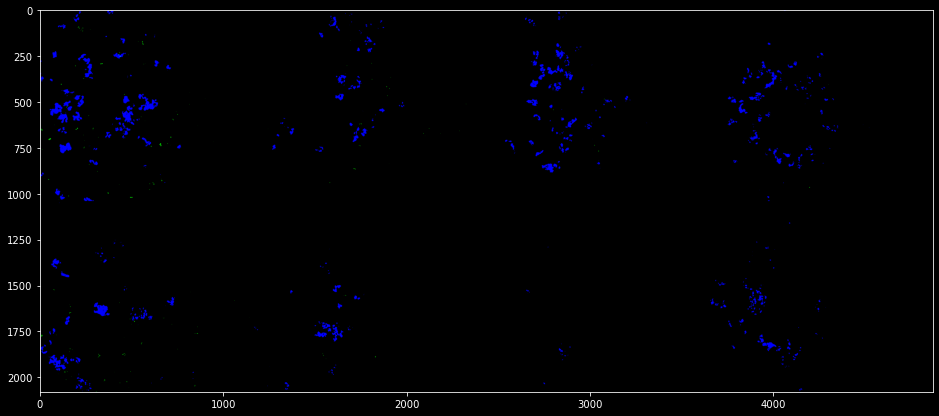

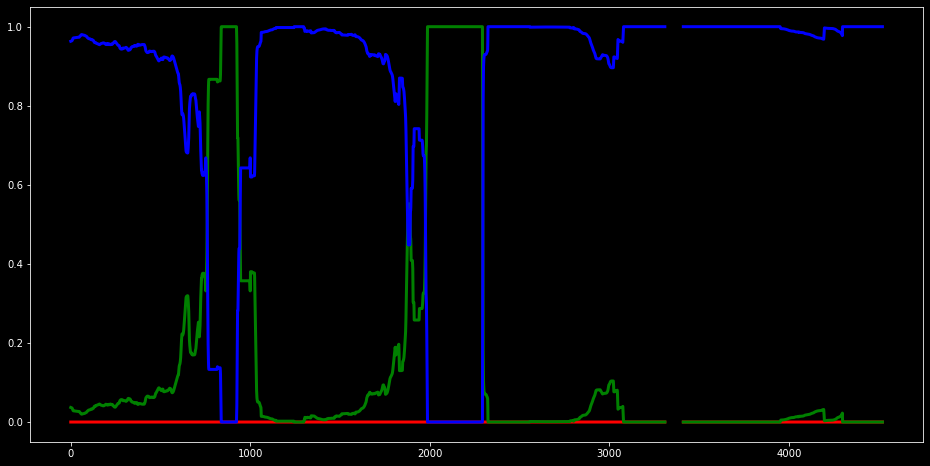

In [33]:
    for carbon, timepoint in zip(["Chitin", "Chito5", "Nag"], ["11.22.21_17", "11.22.21_16", "11.22.21_15"]):
        all_channels = []
        for chi, channel in enumerate(['w4SD RFP', 'w3SD GFP', 'w2SD DAPI']):
            masked_files = glob.glob(image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_w2SD DAPI_s*_masked.TIF')
            masked_files.sort()
            tif_files = glob.glob(image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_{}_s*_wo_bg.TIF'.format(channel))
            tif_files.sort()

            masks = [get_mask(io.imread(masked_file)[0]) for masked_file in masked_files]
            imgs = [io.imread(tif_file) for tif_file in tif_files]
            imgs_filtered = [filter_z(img, thresholds_glob[chi]) for img in imgs]
            imgs_summed = [sum_z(img) for img in imgs_filtered]
            imgs_stitched = simple_stitch(imgs_summed)
            # imgs_stitched = denoise(imgs_stitched)
            imgs_mask = simple_stitch(masks)
            masked_img = mask_img(imgs_stitched, imgs_mask)
            # masked_img = denoise(masked_img)
            img_to_merge = normalize(masked_img)
            all_channels.append(img_to_merge)
            
            empty_img = np.zeros((3, img_to_merge.shape[0], img_to_merge.shape[1]))
            empty_img[chi, :, :] = all_channels[chi]
        
        combined_img = np.transpose(all_channels, (1,2,0))
        
        output = './results/' + timepoint + '_' + carbon + '_1_combined_masked_normalized'
        img_out = output + '.TIF'
        pkl_out = output + '.pkl'
        plot_out = output + '_1d.png'
        
        with open(pkl_out, 'wb') as f:
            pickle.dump(combined_img, f)
        
        plt.figure(figsize=(16,8))
        plt.imshow(combined_img)
        plt.savefig(img_out, dpi=300)

        pop_den = get_pop_density(slide_sum_y(combined_img, combined_img.shape[1]//20))
        colors = ['red', 'green', 'blue']
        plt.figure(figsize=(16,8))
        for i in range(3):
            plt.plot(range(len(pop_den)), pop_den[:,i], color = colors[i], linewidth=3)
        # plt.plot(range(len(pop_den)), pop_den, linewidth=2)
        plt.savefig(plot_out, dpi=300)
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


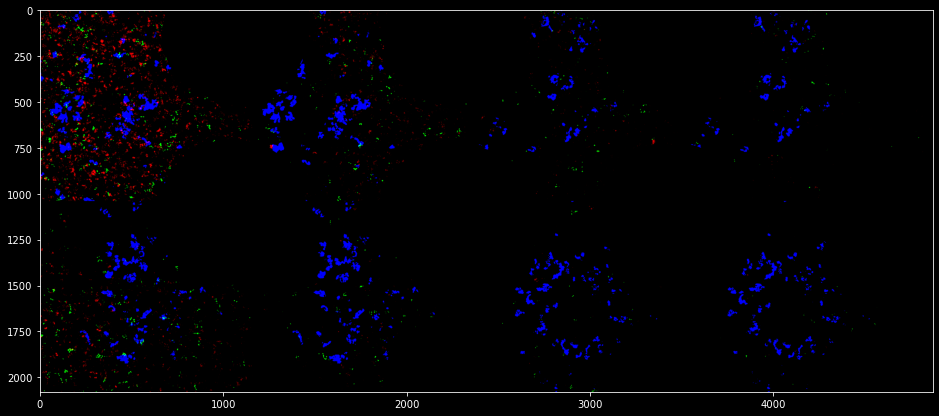

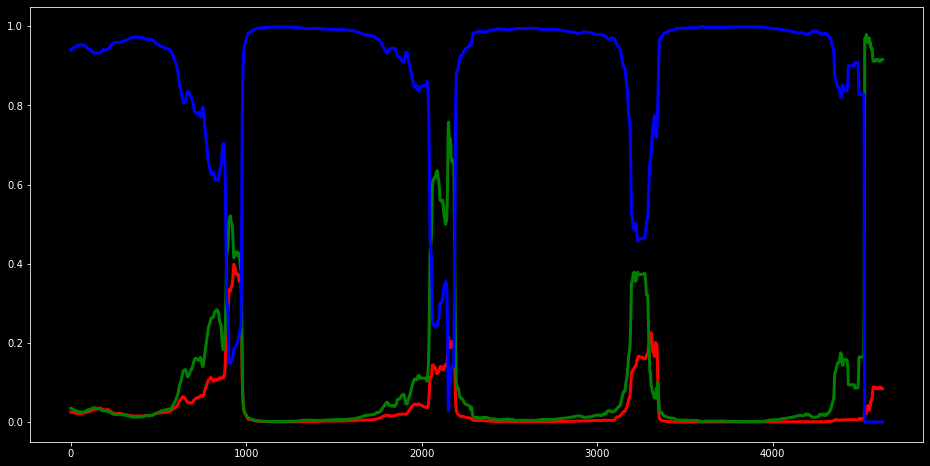

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


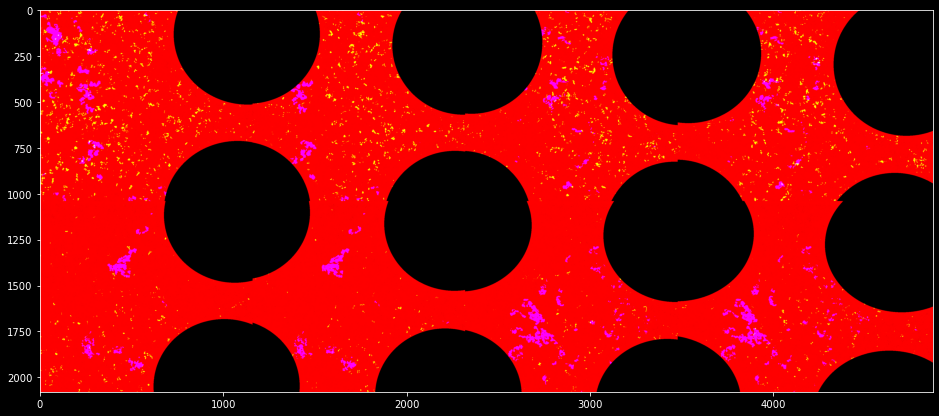

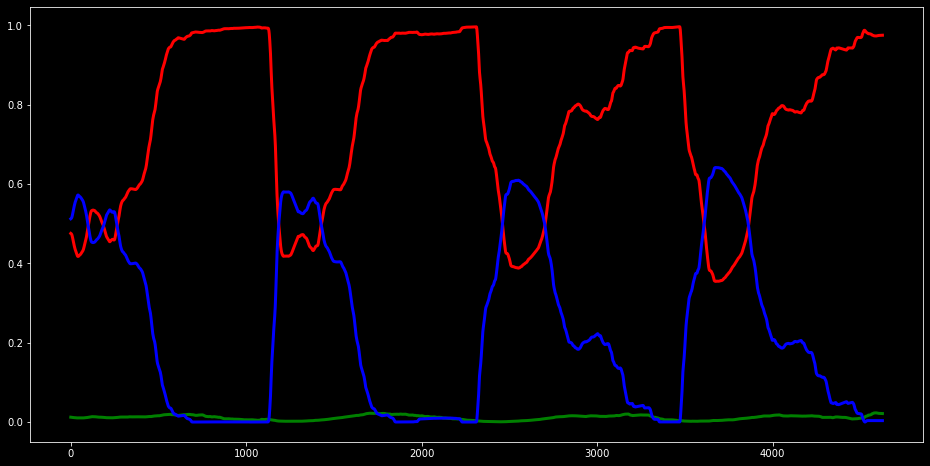

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


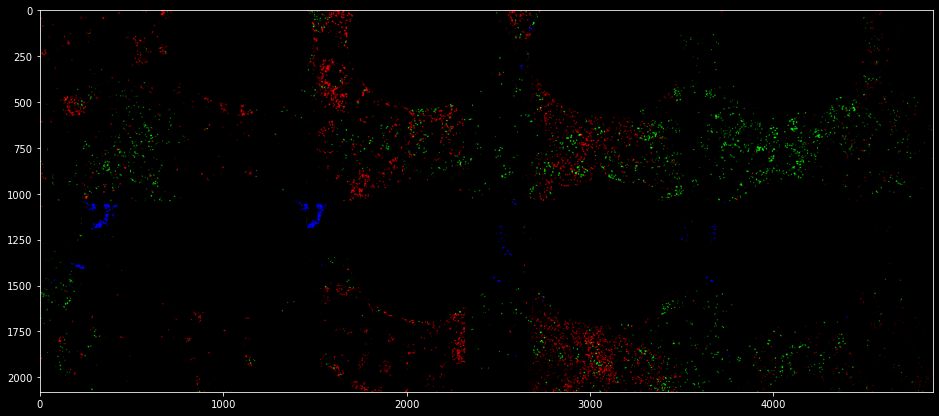

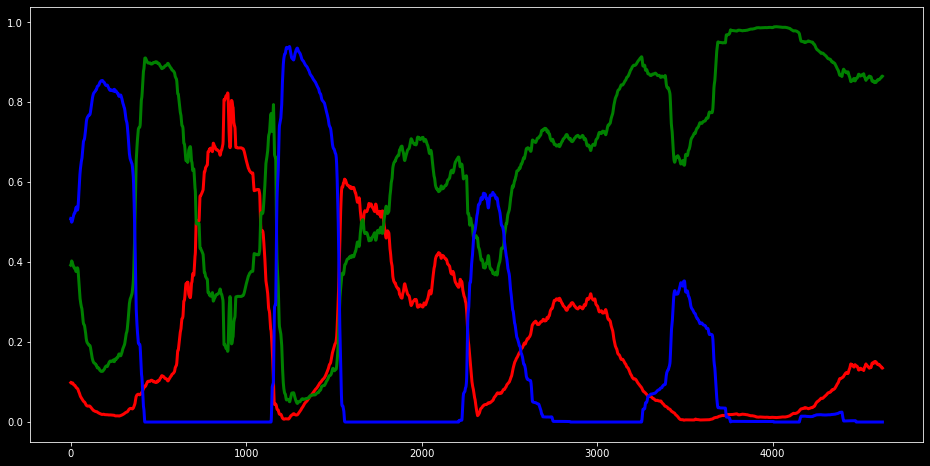

In [ ]:
    for carbon, timepoint in zip(["Chitin", "Chito5", "Nag"], ["11.22.21_17", "11.22.21_16", "11.22.21_15"]):
        all_channels = []
        for chi, channel in enumerate(['w4SD RFP', 'w3SD GFP', 'w2SD DAPI']):
            masked_files = glob.glob(image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_w2SD DAPI_s*_masked.TIF')
            masked_files.sort()
            tif_files = glob.glob(image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_{}_s*_wo_bg.TIF'.format(channel))
            tif_files.sort()

            masks = [get_mask(io.imread(masked_file)[0]) for masked_file in masked_files]
            imgs = [io.imread(tif_file) for tif_file in tif_files]
            imgs_filtered = [filter_z(img, thresholds_glob[chi]) for img in imgs]
            imgs_summed = [sum_z(img) for img in imgs_filtered]
            imgs_stitched = simple_stitch(imgs_summed)
            # imgs_stitched = denoise(imgs_stitched)
            imgs_mask = simple_stitch(masks)
            masked_img = mask_img(imgs_stitched, imgs_mask)
            # masked_img = denoise(masked_img)
            img_to_merge = masked_img
            all_channels.append(img_to_merge)
            
            empty_img = np.zeros((3, img_to_merge.shape[0], img_to_merge.shape[1]))
            empty_img[chi, :, :] = all_channels[chi]
        
        combined_img = np.transpose(all_channels, (1,2,0))
        
        output = './results/' + timepoint + '_' + carbon + '_1_combined_masked'
        img_out = output + '.TIF'
        pkl_out = output + '.pkl'
        plot_out = output + '_1d.png'
        
        with open(pkl_out, 'wb') as f:
            pickle.dump(combined_img, f)
        
        plt.figure(figsize=(16,8))
        plt.imshow(combined_img)
        plt.savefig(img_out, dpi=300)
        
        pop_den = get_pop_density(slide_sum_y(combined_img, combined_img.shape[1]//20))
        colors = ['red', 'green', 'blue']
        plt.figure(figsize=(16,8))
        for i in range(3):
            plt.plot(range(len(pop_den)), pop_den[:,i], color = colors[i], linewidth=3)
        # plt.plot(range(len(pop_den)), pop_den, linewidth=2)
        plt.savefig(plot_out, dpi=300)
        plt.show()


## Merge images

In [ ]:
for carbon in ["Chitin", "Chito5", "Nag"]:
    time_dir = image_dir + '/' + carbon 
    timepoints = [name for name in os.listdir(time_dir) if os.path.isdir(os.path.join(time_dir, name))] 
    timepoints.sort()
    for timepoint in timepoints:
        all_channels = []
        for chi, channel in enumerate(['w4SD RFP', 'w3SD GFP', 'w2SD DAPI']):
            tif_files = glob.glob(image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_{}_s*_wo_bg.TIF'.format(channel))
            tif_files.sort()

            imgs = [io.imread(tif_file) for tif_file in tif_files]
            imgs_filtered = [filter_z(img, thresholds_glob[chi]) for img in imgs]
            imgs_summed = [sum_z(img) for img in imgs_filtered]
            imgs_stitched = simple_stitch(imgs_summed)
            # imgs_stitched = denoise(imgs_stitched)
            img_to_merge = normalize(imgs_stitched)
            all_channels.append(img_to_merge)
            
            empty_img = np.zeros((3, img_to_merge.shape[0], img_to_merge.shape[1]))
            empty_img[chi, :, :] = all_channels[chi]
        
        combined_img = np.transpose(all_channels, (1,2,0))
        
        output = './results/' + timepoint + '_' + carbon + '_1_combined_normalized'
        img_out = output + '.TIF'
        pkl_out = output + '.pkl'
        plot_out = output + '_1d.png'
        
        with open(pkl_out, 'wb') as f:
            pickle.dump(combined_img, f)
        
        plt.figure(figsize=(16,8))
        plt.imshow(combined_img)
        plt.savefig(img_out, dpi=300)
        
        pop_den = get_pop_density(slide_sum_y(combined_img, combined_img.shape[1]//20))
        colors = ['red', 'green', 'blue']
        plt.figure(figsize=(16,8))
        for i in range(3):
            plt.plot(range(len(pop_den)), pop_den[:,i], color = colors[i], linewidth=3)
        # plt.plot(range(len(pop_den)), pop_den, linewidth=2)
        plt.savefig(plot_out, dpi=300)
        plt.show()


In [ ]:
for carbon in ["Chitin", "Chito5", "Nag"]:
    time_dir = image_dir + '/' + carbon 
    timepoints = [name for name in os.listdir(time_dir) if os.path.isdir(os.path.join(time_dir, name))] 
    timepoints.sort()
    for timepoint in timepoints:
        all_channels = []
        for chi, channel in enumerate(['w4SD RFP', 'w3SD GFP', 'w2SD DAPI']):
            tif_files = glob.glob(image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_{}_s*_wo_bg.TIF'.format(channel))
            tif_files.sort()

            imgs = [io.imread(tif_file) for tif_file in tif_files]
            imgs_filtered = [filter_z(img, thresholds_glob[chi]) for img in imgs]
            imgs_summed = [sum_z(img) for img in imgs_filtered]
            imgs_stitched = simple_stitch(imgs_summed)
            # imgs_stitched = denoise(imgs_stitched)
            img_to_merge = imgs_stitched
            all_channels.append(img_to_merge)
            
            empty_img = np.zeros((3, img_to_merge.shape[0], img_to_merge.shape[1]))
            empty_img[chi, :, :] = all_channels[chi]
        
        combined_img = np.transpose(all_channels, (1,2,0))
        
        output = './results/' + timepoint + '_' + carbon + '_1_combined'
        img_out = output + '.TIF'
        pkl_out = output + '.pkl'
        plot_out = output + '_1d.png'
        
        with open(pkl_out, 'wb') as f:
            pickle.dump(combined_img, f)
        
        plt.figure(figsize=(16,8))
        plt.imshow(combined_img)
        plt.savefig(img_out, dpi=300)
        
        pop_den = get_pop_density(slide_sum_y(combined_img, combined_img.shape[1]//20))
        colors = ['red', 'green', 'blue']
        plt.figure(figsize=(16,8))
        for i in range(3):
            plt.plot(range(len(pop_den)), pop_den[:,i], color = colors[i], linewidth=3)
        # plt.plot(range(len(pop_den)), pop_den, linewidth=2)
        plt.savefig(plot_out, dpi=300)
        plt.show()
